In [ ]:
!python /home/bmcv/brainmets/preprocessing/create_tables.py --pData /home/bmcv/data_scratch/StanfordMets512

In [ ]:
!ls /home/bmcv/data_scratch/StanfordMets512

In [ ]:
# System
from os import mkdir
from os.path import join,isdir
from tqdm import tqdm

# Tools: Basic
import cv2
import numpy as np

# Tools: ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models, utils
from torch.autograd import Variable
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch.utils.data import Dataset,DataLoader

from brainmets.nets import deeplabv3_50
from brainmets.data import BravoOnly
from brainmets.data.transforms import *

In [ ]:
criterion = nn.CrossEntropyLoss()

def miou_pytorch(output, Y):
  pred = torch.argmax(output,dim=1)
  miou = 0.0
  for ii in range(1,output.shape[1]):
    intersection = ((pred == ii) & (Y == ii)).float().sum((1,2))
    union        = ((pred == ii) | (Y == ii)).float().sum((1,2))
    miou = (intersection + 1e-6) / (union + 1e-6) / (output.shape[1] - 1)
  return miou.mean()
  
def train_one_epoch(model, opt, dataloaders):
  ious = {}
  losses = {}
  for phase in dataloaders.keys():
    if phase == "train":
      model.train()
    else:
      model.eval()
    
    running_iou = 0.0
    running_loss = 0.0
    for ii,sample_batch in enumerate(dataloaders[phase]):
      X = sample_batch["X"].cuda()
      Y = sample_batch["Y"].cuda()
      with torch.set_grad_enabled(phase=="train"):
        output = model(X)
        loss = criterion(output, Y)
        iou = miou_pytorch(output,Y)
      # Train if necessary
      if phase == "train":
        opt.zero_grad()
        loss.backward()
        opt.step()
      running_iou += iou.item() * X.size(0)
      running_loss += loss.item() * X.size(0)
    ious[phase] = running_iou / len(dataloaders[phase].dataset)
    losses[phase] = running_loss / len(dataloaders[phase].dataset)
    print("  {}: Loss={}, IOU={}".format(phase, losses[phase], ious[phase]))
  return ious,losses

In [ ]:
# Dataloader
bs = 36

path_data_root = "/home/bmcv/data_scratch/StanfordMets512/"

path_csv_tr = join(path_data_root, "train.csv")
path_csv_va = join(path_data_root, "val.csv")

data_tr = BravoOnly(path_csv_tr, resize=512, bloat=10,
                    transform=transforms.Compose([RandomFlip(),
                                                      RandomRotate(),
                                                      RandomShift(),
                                                      ToTensor()]))
data_va = BravoOnly(path_csv_va, resize=512, transform=transforms.Compose([ToTensor()]))

dataloaders = {}
dataloaders["train"] = DataLoader(data_tr, batch_size=bs, shuffle=True, drop_last=True, num_workers=16)
dataloaders["val"] = DataLoader(data_va, batch_size=bs, shuffle=False, drop_last=False, num_workers=16)

In [ ]:
model = deeplabv3_50(in_chan=3, out_chan=2, pretrained=True)
model = nn.DataParallel(model.cuda())

In [ ]:
path_save = join("/home/bmcv/data_scratch", "bravo_only.pth")
opt = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0)

best_iou = 0
for ii in range(100):
  print("Epoch {}".format(ii))
  ious,losses = train_one_epoch(model, opt, dataloaders)
  if ious["val"] >= best_iou:
    best_iou = ious["val"]
    torch.save(model.module.state_dict(), path_save)
    print("  Model Saved!")

In [ ]:
# System
from os.path import join

# Tools: Basic
import cv2
import numpy as np
import nibabel as nib

# Tools: ML
import torch
import torch.nn as nn
import torch.nn.functional as F

from brainmets.nets import deeplabv3_50
from brainmets.utils import preproc_volume,normalize_volume

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams['figure.figsize'] = 16,9

In [ ]:
def run_inference(model, img, vol, xys):
  H,W,_ = vol.shape
  out = np.zeros((H,W))
  X = img.transpose(2,0,1)
  X = X.astype(np.float32)
  X -= X.min()
  X /= X.max() + 1e-6
  X = torch.from_numpy(X).float().unsqueeze(0).cuda()
  with torch.set_grad_enabled(False):
    output = model(X)
    prob = F.softmax(output,dim=1)
  prob = prob.detach().cpu().numpy()[0,1,:,:]

  ymin,ymax,xmin,xmax = xys
  prob = cv2.resize(prob, (xmax-xmin,ymax-ymin))
  out[ymin:ymax, xmin:xmax] = prob
  return out

In [ ]:
path_model = "/home/bmcv/data_scratch/bravo_only.pth"
path_nii = "/home/bmcv/data_nas/StanfordMets/Mets_005/bravo.nii.gz"

# loading in the model
model = deeplabv3_50(in_chan=3, out_chan=2, pretrained=True)
model = model.cuda()
model.load_state_dict(torch.load(path_model))
model.eval()

# creating the volume
vol = nib.load(path_nii).get_fdata()
vol = normalize_volume(vol)
vol_new,xys = preproc_volume(vol)

# looping through the volume
out = np.zeros_like(vol)
for ii in range(1, vol.shape[2] - 1):
    img = vol_new[:, :, (ii - 1):(ii + 2)]
    out[:,:,ii] = run_inference(model, img, vol, xys)

In [ ]:
ind = 36

fig,ax = plt.subplots(1,1)

rgb = np.zeros((vol.shape[0],vol.shape[1],3))
for ii in range(3):
    rgb[:,:,ii] = vol[:,:,ind] * 0.8
rgb[:,:,0] += out[:,:,ind] * 0.2
ax.imshow(rgb)
#ax[0].imshow(vol[:,:,36])
#ax[1].imshow(out[:,:,36])

In [1]:
!python /home/bmcv/brainmets/tools/run_inference_nii.py --pModel /home/bmcv/data_scratch/bravo_only.pth --pNii /home/bmcv/data_nas/StanfordMets/Mets_005/bravo.nii.gz

In [2]:
# System
from os.path import join

# Tools: Basic
import cv2
import numpy as np
import nibabel as nib

# Tools: ML
import torch
import torch.nn as nn
import torch.nn.functional as F

from brainmets.nets import deeplabv3_50
from brainmets.utils import preproc_volume,normalize_volume

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = 16,9

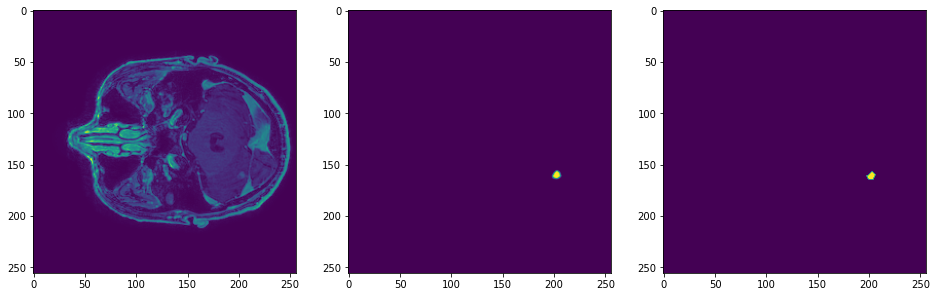

In [4]:
path_img = "/home/bmcv/data_nas/StanfordMets/Mets_005/bravo.nii.gz"
path_out = "/home/bmcv/data_nas/StanfordMets/Mets_005/bravo.nii.gz.out.nii.gz"
path_seg = "/home/bmcv/data_nas/StanfordMets/Mets_005/seg.nii.gz"

vol = nib.load(path_img).get_fdata()
vol = normalize_volume(vol)
out = nib.load(path_out).get_fdata()
out = normalize_volume(out)
seg = nib.load(path_seg).get_fdata()
seg = normalize_volume(seg)

ind = 36
fig,ax = plt.subplots(1,3)
ax[0].imshow(vol[:,:,36])
ax[1].imshow(out[:,:,36])
ax[2].imshow(seg[:,:,36])